# Using Generative Adversarial Networks to generate Handwriten digits.

In this project, we trained a simple generative adversarial network on the MNIST dataset to generate synthetic dataset of the MNIST digits. 

In [49]:
# Importing the libraries
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from time import sleep

from torch.optim import Adam
from torch.nn.utils import parameters_to_vector
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize

# Set the device to CUDA if a gpu with CUDA is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Load and transform the MNIST dataset

In [12]:
# Load the MNIST dataset 
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# Set a dataloader with compose function to apply a series of transformations
train_loader = DataLoader(
        MNIST(
            'data', 
            train=True, 
            download=True, 
            transform=Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])),
            shuffle=True,
            batch_size=64,
            drop_last=True
)

img_width = 28
n_channels = 1
train_iterator = iter(cycle(train_loader))

> Size of training dataset 60000


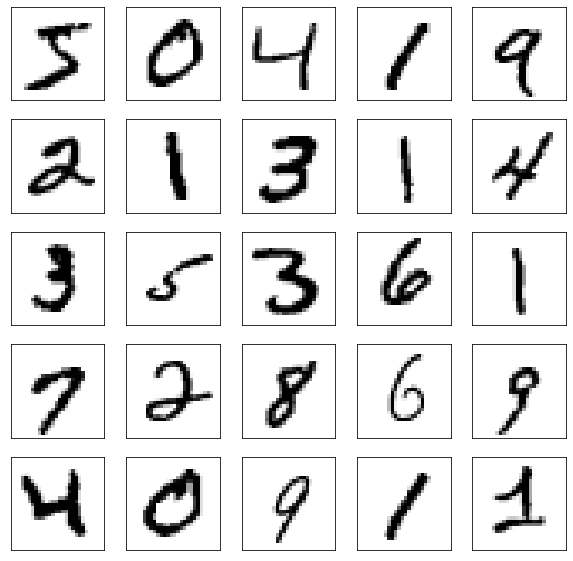

In [24]:
# Plot some of the samples from the dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_loader.dataset[i][0].numpy().reshape(28,28), cmap=plt.cm.binary)

### Define the generator and the discriminator

Here we define the architecture of the generator and the discriminator model. 
The parameter latent_size used in defining the generator architecture, is the size of the noise vector that the generator takes as input. For every random vector z of size=100, the generator returns random images of shape (1,28,28).

The discriminator takes images of size (1,28,28) from the generator and returns the probability of the image being real. 

In [25]:
# Define the generator 
class Generator(nn.Module):
    def __init__(self, latent_size=100):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            # latent_size --> 128
            nn.Linear(latent_size, 128),
            nn.LeakyReLU(0.2),
            # 128 --> 256
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            # 256 --> 512
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            # 512 --> 1024
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            # 512 --> n_channels*width*height
            nn.Linear(1024, n_channels*img_width*img_width),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0), n_channels, img_width, img_width)
        return x

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            # channels*width*height --> 512
            nn.Linear(n_channels*img_width*img_width, 512),
            nn.LeakyReLU(0.2),
            # 512 --> 256
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            # 256 --> 1
            nn.Linear(256, 1), # 1 output for real/fake
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer(x)
        return x

In [27]:
G = Generator().to(device)
D = Discriminator().to(device)

print(f'> Number of generator parameters {len(parameters_to_vector(G.parameters()))}')
print(f'> Number of discriminator parameters {len(parameters_to_vector(D.parameters()))}')

> Number of generator parameters 1510032
> Number of discriminator parameters 533505


We see that the generator is over parameterised as compared to the discriminator. 

### Set the optimizers and the loss function

In [29]:
# initialise the optimiser
optimiser_G = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimiser_D = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()

### Training the generator and the discriminator

loss d: 0.816, loss g: 0.642


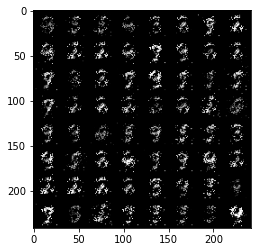

loss d: 0.912, loss g: 0.608


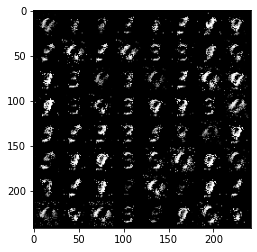

loss d: 0.912, loss g: 0.566


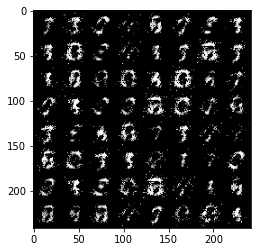

loss d: 0.983, loss g: 0.535


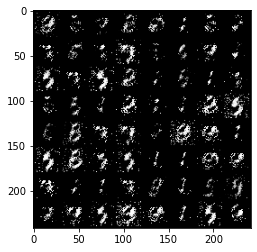

loss d: 1.071, loss g: 0.484


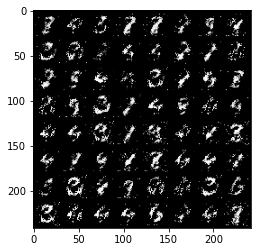

loss d: 1.067, loss g: 0.485


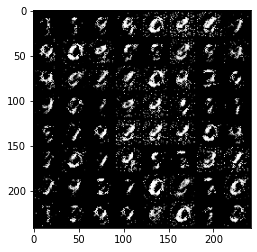

loss d: 1.173, loss g: 0.436


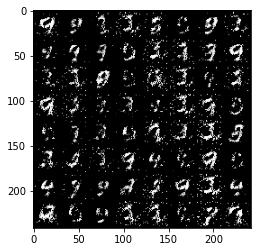

loss d: 1.221, loss g: 0.429


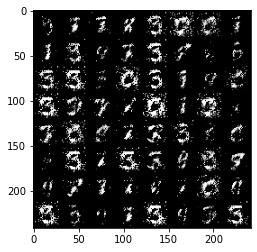

loss d: 1.236, loss g: 0.435


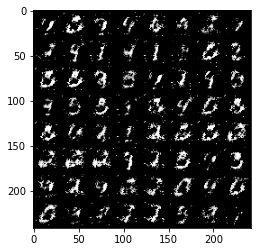

loss d: 1.359, loss g: 0.383


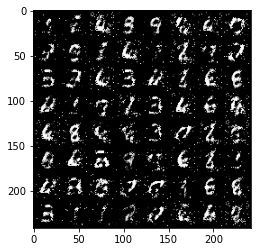

loss d: 1.369, loss g: 0.369


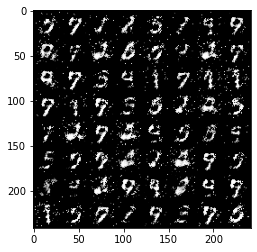

loss d: 1.225, loss g: 0.427


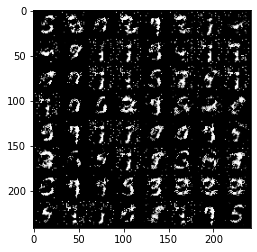

loss d: 1.321, loss g: 0.385


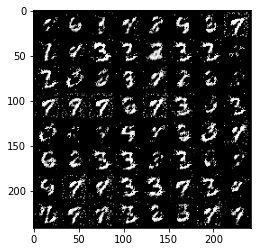

loss d: 1.347, loss g: 0.389


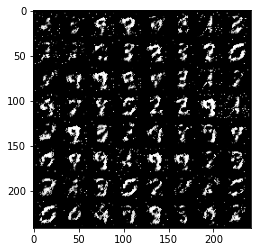

loss d: 1.302, loss g: 0.423


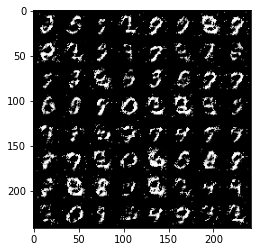

loss d: 1.246, loss g: 0.405


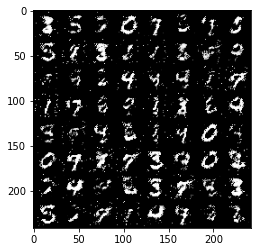

loss d: 1.197, loss g: 0.423


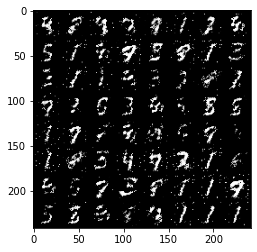

loss d: 1.015, loss g: 0.576


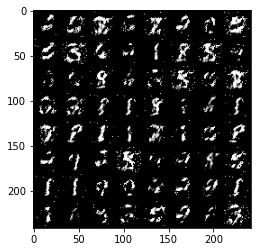

loss d: 1.313, loss g: 0.387


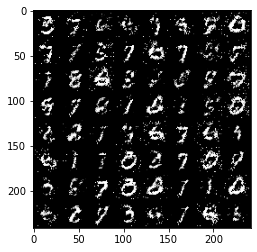

loss d: 1.132, loss g: 0.427


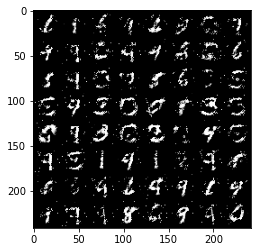

In [50]:
epoch = 20

# training loop
for _ in range(epoch):
    
    # arrays for metrics
    logs = {}
    gen_loss = np.zeros(0)
    dis_loss = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(500):
        img_arr, labels = next(train_iterator)
        img_arr, labels = img_arr.to(device), labels.to(device)

        # train discriminator 
        g = G(torch.randn(img_arr.size(0), 100).to(device))
        # calculate the loss of the real image and the fake image generated by the generator
        loss_real = bce_loss(D(img_arr).mean(), torch.ones(1)[0].to(device)) # real -> 1
        loss_fake = bce_loss(D(g.detach()).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
        
        # Take the average of both the losses
        loss_dis = (loss_real + loss_fake)/2.0
        
        # Optimize the parameters of the discriminator
        optimiser_D.zero_grad()
        loss_dis.backward()
        optimiser_D.step()
        
        # train generator
        g = G(torch.randn(img_arr.size(0), 100).to(device))
        loss_gen = bce_loss(D(g).mean(), torch.ones(1)[0].to(device)) # fake -> 1
        
        # Optimize the parameters of the generator
        optimiser_G.zero_grad()
        loss_gen.backward()
        optimiser_G.step()

        gen_loss = np.append(gen_loss, loss_gen.item())
        dis_loss = np.append(dis_loss, loss_dis.item())

    # plot some examples
    G.eval()
    g = G(torch.randn(img_arr.size(0), 100).to(device))
    print('loss d: {:.3f}, loss g: {:.3f}'.format(gen_loss.mean(), dis_loss.mean()))
    plt.grid(False)
    plt.imshow(make_grid(g).cpu().data.clamp(0,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)
    G.train()

We see above that after the 20th epoch the trained Generator can produce images that resemble the MNIST dataset very roughly. However, we can train the model for more epochs or use other GAN models such as conditional GANs or DCGANs to improve our results. 